http://docs.pymc.io/notebooks/GLM-hierarchical.html or a random effects model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, linregress
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import scale

tracts_data_path = 'data/features.csv'

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dtypes = {'GEOID' : str,
          'place_geoid' : str,
          'state' : str,
          'county' : str}

df = pd.read_csv(tracts_data_path, encoding='utf-8', dtype=dtypes)
df = df.rename(columns={'GEOID' : 'tract'}).set_index('tract')
assert df.index.is_unique

In [3]:
print(len(df))
df.head()

12505


,land_area,place_geoid,place_name,total_pop,median_age,pct_hispanic,pct_white,pct_black,pct_single_fam_detached,med_rooms_in_house,...,pct_burden,median_gross_rent_k,med_income_k,med_home_value_k,pct_white_change_2012_2015,clist_count,prop_count,bias_difference,bias_ratio,bias_log
tract,,,,,,,,,,,,,,,,,,,,,
01073000100,7549578,0107000,"Birmingham, AL",2970.0,32.2,4.6,17.1,78.5,70.5,5.1,...,60.4,0.754,24.359,68.4,1.4,3,2.150039,0.849961,1.395324,0.873518
01073000300,2093104,0107000,"Birmingham, AL",2494.0,36.5,18.0,4.6,67.2,32.6,4.5,...,53.4,0.552,20.425,65.3,-2.2,1,2.852092,-1.852092,0.350620,0.300564
01073000400,8001582,0107000,"Birmingham, AL",3437.0,30.6,0.7,7.9,90.8,89.7,5.7,...,74.7,0.912,21.759,60.7,2.5,2,2.120786,-0.120786,0.943046,0.664257
01073000500,4819145,0107000,"Birmingham, AL",3735.0,35.8,1.4,5.0,92.9,54.6,4.7,...,54.7,0.534,21.430,53.7,1.1,0,3.426167,-3.426167,0.000000,0.000000
01073000700,3520564,0107000,"Birmingham, AL",2562.0,25.4,2.5,0.0,97.7,56.9,5.1,...,77.3,0.505,15.833,52.4,-0.1,0,2.135412,-2.135412,0.000000,0.000000


## determine if tracts are over or under represented

In [4]:
overrepresent_var = 'bias_ratio'
overrepresent_value = 1

In [5]:
# divide data into two subsets: overrepresented and underrepresented (latter includes perfectly proportional)
mask = df[overrepresent_var] > 1
over = df[mask]
under = df[~mask]
print(len(over), len(under))

3078 9427


In [6]:
# make a dummy to indicate if tract is overrepresented
df['is_over'] = df[overrepresent_var].map(lambda x: 1 if x > 1 else 0)
df['is_over'].value_counts()

0    9427
1    3078
Name: is_over, dtype: int64

## *t*-tests and effect sizes for significant differences in variables

Divide the data into two subsets: overrepresented and underrepresented, then test if variables' means differ significantly between them.

In [7]:
# t-test: how do demographic vars differ between the two data sets?
variables = ['pct_hispanic', 'pct_white', 'pct_black', 'pct_single_fam_detached',
             'med_home_value_k', 'med_rooms_in_house', 'pct_built_before_1940',
             'pct_renting', 'renter_occupied_units_km', 'rental_vacancy_rate',
             'renter_household_size', 'med_income_k', 'mean_travel_time_work',
             'pct_commute_drive_alone', 'pct_below_poverty', 'median_age',
             'pct_nonrelatives_household', 'pct_same_residence_year_ago',
             'pct_bachelors_or_higher', 'pct_english_only', 'pct_foreign_born',
             'pop_density_k_km', 'pct_20_34', 'pct_burden', 'distance_to_center_km',
             'pct_white_change_2012_2015', 'median_gross_rent_k']
    
# effect size: as cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    return d

def test_variables(subset1, subset2, variables):
    test_results = {}
    for var in variables:
        a = subset1[var]
        b = subset2[var]
        t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit')
        diff = subset1[var].mean() - subset2[var].mean()
        d_value = cohen_d(x=a, y=b)
        test_results[var] = {'diff_mean' : round(diff, 2),
                             't_stat' : round(t_statistic, 2),
                             'p_value' : round(p_value, 3),
                             'cohen_d' : round(d_value, 2)}
    return test_results

In [8]:
# variables' effect sizes between over and underrepresented tracts
results = test_variables(over, under, variables)
effect_sizes = pd.DataFrame(results).T.sort_values('cohen_d', ascending=False)
effect_sizes.reindex(columns=['cohen_d', 'diff_mean', 't_stat', 'p_value'])

,cohen_d,diff_mean,t_stat,p_value
pct_bachelors_or_higher,0.80,17.10,35.25,0.000
med_income_k,0.59,17.08,24.46,0.000
pct_white,0.58,16.97,28.83,0.000
median_gross_rent_k,0.49,0.18,21.18,0.000
pct_20_34,0.38,3.88,15.20,0.000
pct_english_only,0.37,9.24,20.50,0.000
pct_nonrelatives_household,0.36,2.19,14.99,0.000
med_home_value_k,0.33,74.51,14.23,0.000
median_age,0.10,0.68,4.90,0.000
rental_vacancy_rate,0.07,0.44,3.17,0.002


In [9]:
variables_subset = ['pct_white', 'pct_nonrelatives_household', 'pct_below_poverty', 'pct_20_34',
                    'pct_bachelors_or_higher', 'med_income_k', 'mean_travel_time_work', 'median_gross_rent_k']

def significance(p):
    if p <= 0.01:
        return '^'
    elif p <= 0.05:
        return '*'
    else:
        return ''

city_results = {}
for city, group in df.groupby('place_name'):
    mask = group[overrepresent_var] > 1
    group_over = group[mask]
    group_under = group[~mask]
    group_results = test_variables(group_over, group_under, variables_subset)
    var_d = {k:'{}{}'.format(v['cohen_d'], significance(v['p_value'])) for k, v in group_results.items()}
    city_results[city] = var_d

In [10]:
city_effect_sizes = pd.DataFrame(city_results).T
city_effect_sizes.index = city_effect_sizes.index.map(lambda x: x.split(', ')[0])
city_effect_sizes
#city_effect_sizes.sort_values(by='median_gross_rent')

,mean_travel_time_work,med_income_k,median_gross_rent_k,pct_20_34,pct_bachelors_or_higher,pct_below_poverty,pct_nonrelatives_household,pct_white
Atlanta,-0.55^,0.37,0.55*,0.31,0.59^,-0.37*,0.21,0.49^
Austin,-0.27,0.44^,0.45^,-0.02,0.72^,-0.26,0.17,0.7^
Baltimore,-0.61^,0.8^,0.71^,1.05^,1.33^,-0.59^,0.84^,1.15^
Birmingham,-0.03,0.79^,0.89^,0.01,0.71^,-0.87^,-0.08,0.5*
Boston,-0.95^,0.36,1.14^,1.21^,1.36^,-0.01,0.93^,0.92^
Buffalo,-0.01,0.34,0.61*,0.37,0.2,0.0,0.48,0.17
Charlotte,-0.09,0.23,0.23,0.3,0.35*,-0.31,0.13,0.16
Chicago,-0.9^,1.34^,1.53^,1.36^,1.74^,-0.61^,1.22^,1.15^
Cincinnati,-0.79^,0.45*,0.83^,0.68^,0.75^,-0.2,0.98^,0.62^
Cleveland,-0.33*,0.3,0.24,0.41*,0.42*,-0.27,0.25,0.26


In [11]:
# these variables have at least a small-medium effect size nationwide
vars_with_effect = effect_sizes[effect_sizes['cohen_d'].abs() >= 0.35].index

"Cohen suggested that d=0.2 be considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This means that if two groups' means don't differ by 0.2 standard deviations or more, the difference is trivial, even if it is statistically signficant."

Perhaps we can interpret small-medium effect size as absolute value 0.35 <= x < 0.5?

d is not affected by units/sizes. So income and income_k will have same d.

## Show a simple bivariate regression to explore relationship between variables

In [12]:
df_notnull = df.dropna()
len(df_notnull)

11915

In [13]:
# bivariate regression, show r^2 and p-value and plot
def bivariate_regress(y_var, x_var):

    # first regress y on x to get slope, intercept, r, p-value, and std error
    x = df_notnull[x_var]
    y = df_notnull[y_var]
    m, b, r, p, std_err = linregress(x=x, y=y)
    y_line = m * x + b
    
    title = '{} vs {}\n r^2={:.3f}, p={:.4f}'.format(y_var, x_var, r**2, p)

    # then scatterplot with bivariate line
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(x, y, s=2, marker='.', zorder=1)
    ax.plot(x, y_line, c='k', alpha=0.5, linewidth=0.5, zorder=2)
    ax.set_xlim((x.min(), x.max()))
    ax.set_ylim((y.min(), y.max()))
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_title(title)
    plt.show()

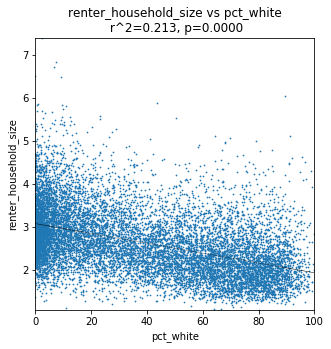

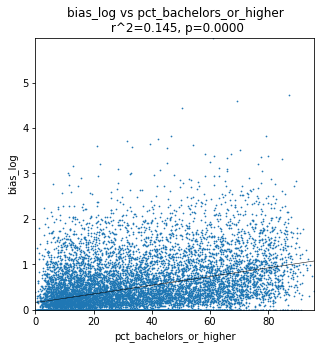

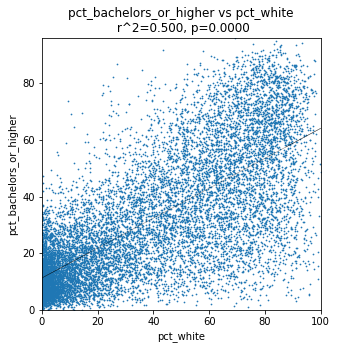

In [14]:
var_pairs = [('renter_household_size', 'pct_white'),
             ('bias_log', 'pct_bachelors_or_higher'),
             ('pct_bachelors_or_higher', 'pct_white')]

for y_var, x_var in var_pairs:
    bivariate_regress(y_var, x_var)

## Estimate regression models to predict Craigslist over- or under-representation

In [15]:
# here are our features
df.columns.sort_values()

Index(['bias_difference', 'bias_log', 'bias_ratio', 'centroid', 'clist_count',
       'count_renter_occupied_units', 'county', 'distance_to_center_km',
       'geometry', 'is_over', 'land_area', 'lat_city_center',
       'lng_city_center', 'mean_travel_time_work', 'med_home_value_k',
       'med_income_k', 'med_rooms_in_house', 'median_age',
       'median_gross_rent_k', 'pct_20_34', 'pct_bachelors_or_higher',
       'pct_below_poverty', 'pct_black', 'pct_built_before_1940', 'pct_burden',
       'pct_commute_drive_alone', 'pct_english_only', 'pct_foreign_born',
       'pct_hispanic', 'pct_nonrelatives_household', 'pct_renting',
       'pct_same_residence_year_ago', 'pct_single_fam_detached', 'pct_white',
       'pct_white_change_2012_2015', 'place_geoid', 'place_name',
       'pop_density_k_km', 'prop_count', 'rental_vacancy_rate',
       'renter_household_size', 'renter_occupied_units_km', 'state',
       'total_pop'],
      dtype='object')

In [16]:
# these have at least a small-medium effect size (see above)
sorted(vars_with_effect)

['mean_travel_time_work',
 'med_income_k',
 'median_gross_rent_k',
 'pct_20_34',
 'pct_bachelors_or_higher',
 'pct_below_poverty',
 'pct_burden',
 'pct_english_only',
 'pct_hispanic',
 'pct_nonrelatives_household',
 'pct_same_residence_year_ago',
 'pct_white',
 'renter_household_size']

In [17]:
# estimate a model across the full data set (all counties)
X = df_notnull[vars_with_effect]
y = df_notnull['bias_log']
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     998.2
Date:                Fri, 02 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:58:07   Log-Likelihood:                -8787.7
No. Observations:               11915   AIC:                         1.760e+04
Df Residuals:                   11902   BIC:                         1.770e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
pct_bachelors_or_h

In [18]:
# estimate a reduced model across the full data set (all counties)
formula = 'bias_log ~ med_income_k + pct_20_34 + pct_bachelors_or_higher + pct_white'
model = smf.ols(formula=formula, data=df_notnull)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               bias_log   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     561.8
Date:                Fri, 02 Mar 2018   Prob (F-statistic):               0.00
Time:                        14:58:07   Log-Likelihood:                -9080.3
No. Observations:               11915   AIC:                         1.817e+04
Df Residuals:                   11910   BIC:                         1.821e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

#### and a regression for just one city

In [19]:
# subset data for a single city
place_name = 'New York, NY'
df_city = df[df['place_name']==place_name]
print(sum(df_city['bias_ratio']>1), sum(df_city['bias_ratio']<=1))

449 1663


In [20]:
# estimate a model for this single city
formula = 'bias_ratio ~ med_income_k + pct_20_34 + pct_bachelors_or_higher + pct_white'
model = smf.ols(formula=formula, data=df_city)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             bias_ratio   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     67.50
Date:                Fri, 02 Mar 2018   Prob (F-statistic):           8.21e-54
Time:                        14:58:07   Log-Likelihood:                -5509.5
No. Observations:                2111   AIC:                         1.103e+04
Df Residuals:                    2106   BIC:                         1.106e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

^^ multicollinearity can produce large standard errors in the related variables

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plot
from shapely.wkt import loads as wkt_loads

In [22]:
geometry = df_city['geometry'].map(wkt_loads)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

C:\Anaconda\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


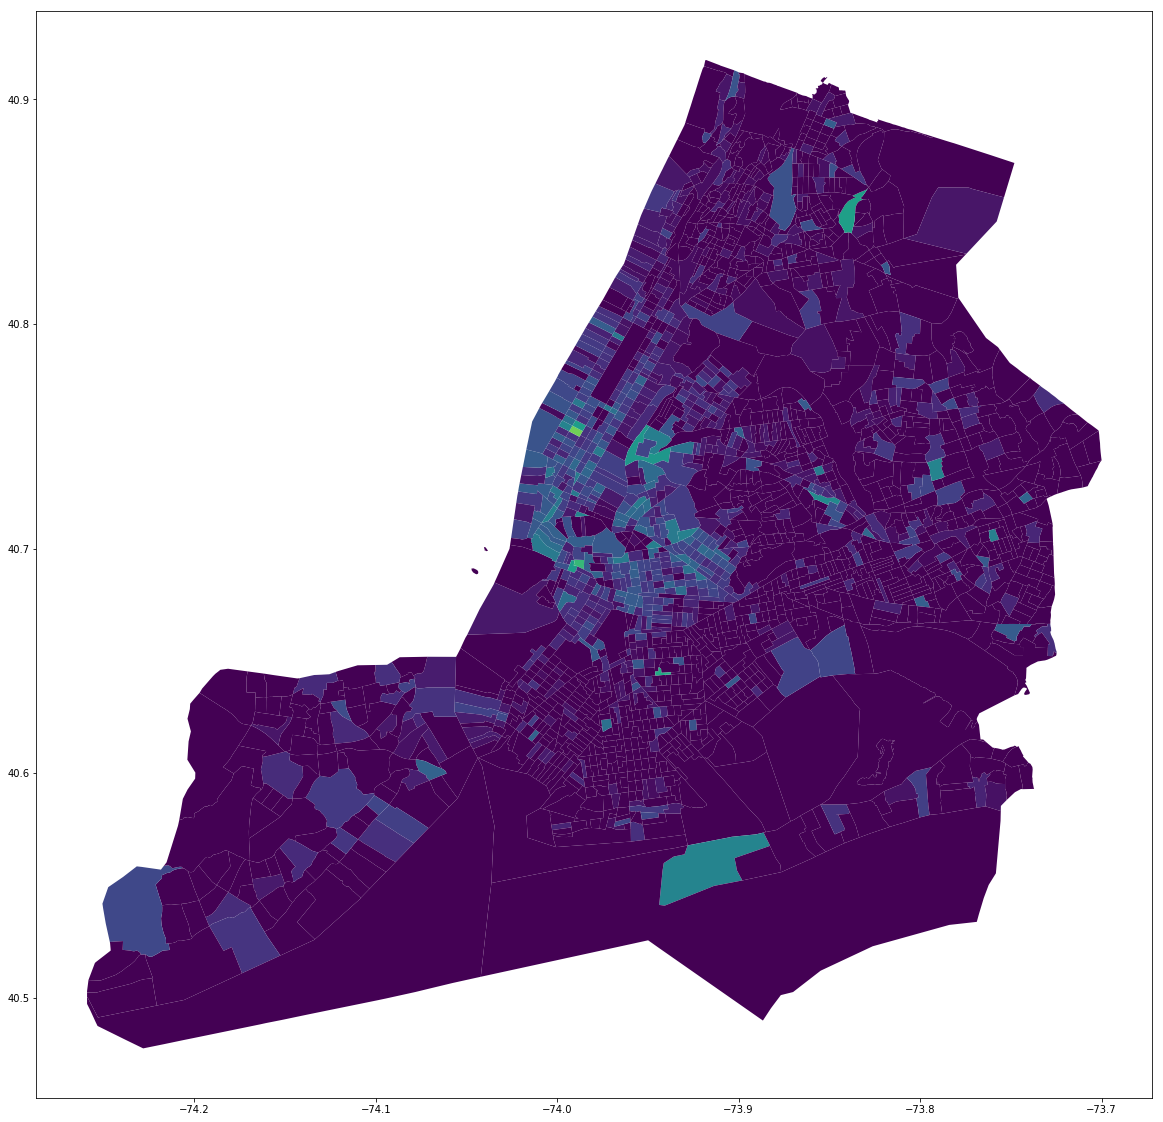

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
plot = gdf.plot(ax=ax, column='bias_log', cmap='viridis')

## Logit models

In [24]:
# short-term fix before statsmodels 0.9 release fixes a bug
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [25]:
# predict whether or not tract is overrepresented on craigslist (yes/no)
formula = 'is_over ~ med_income_k + pct_20_34 + pct_bachelors_or_higher + pct_white '
model = smf.logit(formula=formula, data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.505913
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                is_over   No. Observations:                12320
Model:                          Logit   Df Residuals:                    12315
Method:                           MLE   Df Model:                            4
Date:                Fri, 02 Mar 2018   Pseudo R-squ.:                  0.1000
Time:                        14:58:08   Log-Likelihood:                -6232.8
converged:                       True   LL-Null:                       -6925.8
                                        LLR p-value:                8.117e-299
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.9738      0.086    -34.688      0.000      -3.142   

In [26]:
# multicollinearity with demographic vars?

## Dimensionality reduction

### pca

In [27]:
y = df_notnull['bias_log']
X = df_notnull[['med_income_k', 'pct_20_34', 'pct_bachelors_or_higher',
                'pct_black', 'pct_white', 'renter_household_size']]
X = pd.DataFrame(scale(X.values), columns=X.columns)

In [28]:
# n dimensions
n = 4
pca = PCA(n_components=n)
pca.fit(X=X, y=y)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
# amount of variance that each component explains
pca.explained_variance_ratio_

array([0.50157463, 0.2067588 , 0.14414664, 0.09241884])

In [30]:
# cumulative variance explained
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3))

array([0.502, 0.709, 0.853, 0.945])

In [31]:
labels = ['PC{}'.format(i+1) for i in range(n)]
pd.DataFrame(pca.components_, columns=X.columns, index=labels)

,med_income_k,pct_20_34,pct_bachelors_or_higher,pct_black,pct_white,renter_household_size
PC1,0.436368,0.167754,0.527516,-0.382895,0.509639,-0.311173
PC2,0.414528,-0.666205,-0.071045,-0.282008,0.058406,0.544381
PC3,-0.181804,0.571620,-0.148461,-0.597506,-0.015865,0.510776
PC4,0.511520,0.363316,0.368314,0.423047,-0.398078,0.365044


### factor analysis

In [32]:
# n dimensions
n = 4
fa = FactorAnalysis(n_components=n)
fa.fit(X=X, y=y)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=4,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=0.01)

In [33]:
labels = ['PC{}'.format(i+1) for i in range(n)]
pd.DataFrame(fa.components_, columns=X.columns, index=labels)

,med_income_k,pct_20_34,pct_bachelors_or_higher,pct_black,pct_white,renter_household_size
PC1,0.825997,0.213944,0.944922,-0.548426,0.799018,-0.470567
PC2,0.441174,-0.635145,-0.134253,-0.142477,-0.081552,0.590482
PC3,0.119496,-0.127315,0.122591,0.624199,-0.339901,-0.166358
PC4,0.043954,0.485098,0.067888,-0.105228,-0.255900,0.365652
